In [ ]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats
import os
import random

from google.colab import drive
drive.mount('/drive')

Mounted at /drive


**Analyzing uncertainty of a well performing model**

In [ ]:
import tensorflow as tf
tf.__version__
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models

In [ ]:
#Load in a model saved from server - should be near best
m = tf.keras.models.load_model('/drive/MyDrive/Colab Notebooks/Thesis Notebooks/wholeBestModel')
#m.summary()

In [ ]:
def getDataGen(tfrecordPaths, shuffle=False):
    random.seed(10)
    def decode(serialized_example):
            features = {
                "feature0": tf.io.FixedLenFeature([32000,1], tf.float32),
                "label": tf.io.FixedLenFeature([], tf.int64),
         }
            example = tf.io.parse_single_example(serialized_example, features)

            feature0 = example['feature0']
            label = example['label']
            return (feature0,
                    label)
    
    dataset = tf.data.TFRecordDataset(tfrecordPaths)
    dataset = dataset.map(decode) 
    if shuffle==True:
      dataset = dataset.shuffle(8000) #This ensures all data is shuffled before being outputted
    return dataset

tfRecordsDir = "/drive/MyDrive/Colab Notebooks/Thesis Notebooks/testData/"
testDataFiles = (tfRecordsDir+"fold10/ubs.tfRecord_0",tfRecordsDir+"fold10/ubs.tfRecord_1")
datasetTest = getDataGen(testDataFiles) #datasetTest contains 837 elements, this remains unchanged
batchTest = datasetTest.batch(400, drop_remainder=False)


In [ ]:
def test(x, y, m, n):
    """
    outputs two accuracies: one calculated based on the predictions garnered from
    averaging n softmax distributions of event size 10, and one garnered from taking the mode
    of the labels predicted based on the n softmax distributions.
    """
    preds = [] 
    predLabels = [] 
    accs=[]
    
    for i in range(n):
        pred = m(x, training = False)
        preds.append(pred.numpy())
    
    finalPredSoftmax = np.mean(np.array(preds), axis=0)
    finalPredLabel = np.argmax(finalPredSoftmax, axis = 1)
    #Calculate accuracy against y
    totalNumCorrect = sum(finalPredLabel == y)
    totalNum = x.shape[0]
    acc = totalNumCorrect/totalNum
    return acc, finalPredSoftmax

def testMetrics(dataSet, m, numsPredictionsToAverage = [10, 10, 10, 10, 10]):
    random.seed(10)
    x, y = list(dataSet.batch(1000))[0] #We just take 1000 cuz it's bigger than test set size
    x = x.numpy()
    y = y.numpy()
    accList = []
    predSoftmaxList = []
    for i in numsPredictionsToAverage:
        acc, predSoftmax = test(x, y, m, i)
        accList.append(acc)
        predSoftmaxList.append(predSoftmax)
    return accList, predSoftmaxList

In [ ]:
x_test, y_test = list(datasetTest.batch(1000))[0] #We just take 1000 cuz it's bigger than test set size
x_test = x_test.numpy()
y_test = y_test.numpy()

In [ ]:
classDict = {0 : "air_conditioner",
  1 : "car_horn",
  2 : "children_playing",
  3 : "dog_bark",
  4 : "drilling",
  5 : "engine_idling",
  6 : "gun_shot",
  7 : "jackhammer",
  8 : "siren",
  9 : "street_music"}

In [ ]:
classList = ["air_conditioner","car_horn","children_playing","dog_bark","drilling","engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]

In [ ]:
def analyse_model_predictions(ind, mcSamples=1):
    # Print the true activity
    print('------------------------------')
    print('True category:', str(y_test[ind]))
    print('')

    # Print the probabilities the model assigns
    print('------------------------------')
    print('Model estimated probabilities:')
    # Create ensemble of predicted probabilities
    predicted_probabilities = np.empty(shape=(200, 10))
    for i in range(200):
        predicted_probabilities[i] = np.mean(np.array([m(x_test[ind][np.newaxis, ...]).numpy()[0] for i in range(mcSamples)]), axis=0)

    wrongLabels = list(range(0,y_test[ind]))+list(range(1+y_test[ind],10))
    colDict = {wrongLabel : "r" for wrongLabel in wrongLabels }
    colDict[y_test[ind]]="g"
    
    predLabels = np.argmax(predicted_probabilities, axis=1)
    labelCounts = [sum(n==predLabels) for n in range(10)]
    accuracy = 100*labelCounts[y_test[ind]]/200

    #Plot the bar chart
    hist = plt.bar(classList, labelCounts, color=[colDict[n] for n in range(10)])
    plt.title('Predictions Distribution ({:.1f}% correct)'.format(accuracy))
    plt.xlabel("Class", fontsize = 12)
    plt.ylabel("Prediction Count", fontsize = 12)
    plt.xticks(rotation=60)
    plt.show();

    #Plot the boxplot
    bp = sns.boxplot(data=predicted_probabilities, fliersize=1, palette=colDict);
    bp.set_xticklabels(classList)
    bp.set_xlabel("Class", fontsize = 12)
    bp.set_ylabel("Probability", fontsize = 12)
    plt.xticks(rotation=60)
    plt.show();

------------------------------
True category: 1

------------------------------
Model estimated probabilities:


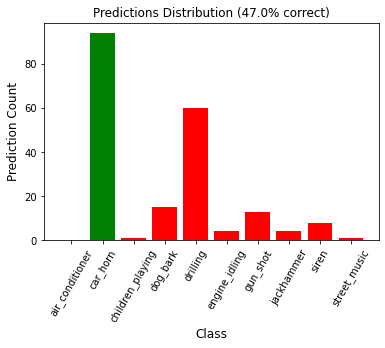

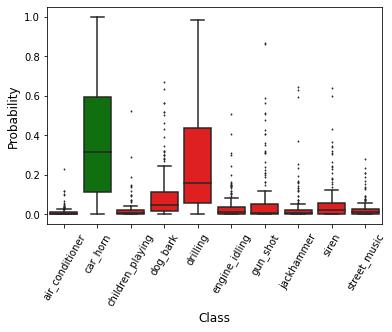

In [ ]:
analyse_model_predictions(3)

------------------------------
True category: 1

------------------------------
Model estimated probabilities:


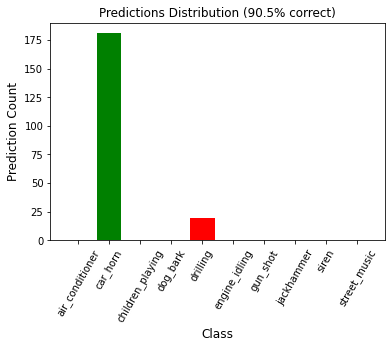

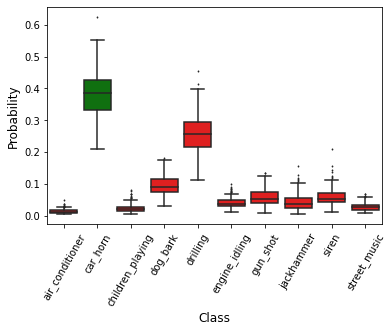

In [ ]:
analyse_model_predictions(3, mcSamples=20)

------------------------------
True category: 5

------------------------------
Model estimated probabilities:


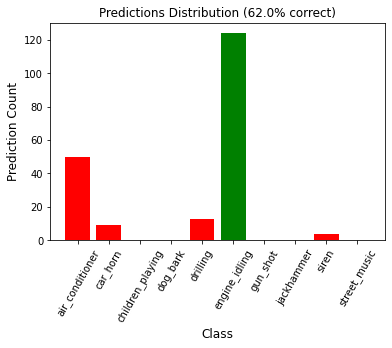

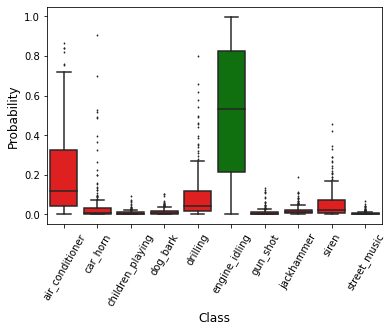

In [ ]:
analyse_model_predictions(30)

------------------------------
True category: 5

------------------------------
Model estimated probabilities:


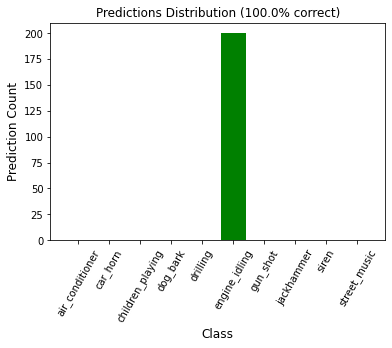

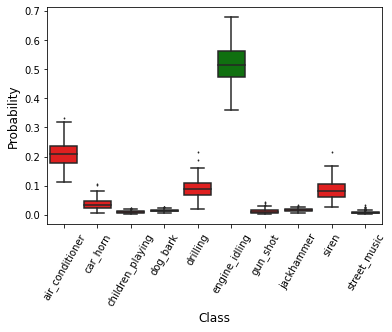

In [ ]:
analyse_model_predictions(30, mcSamples=20)

------------------------------
True category: 1

------------------------------
Model estimated probabilities:


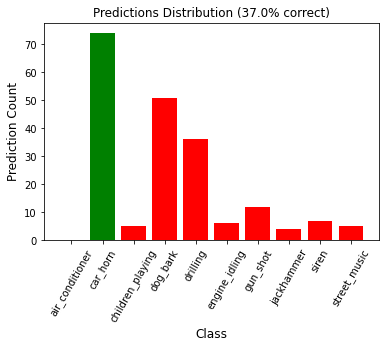

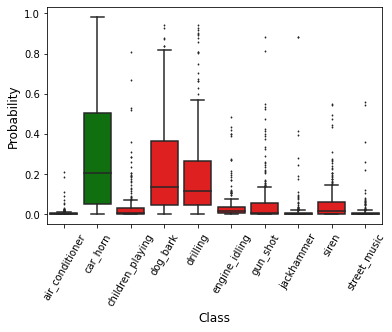

In [ ]:
analyse_model_predictions(1)

------------------------------
True category: 1

------------------------------
Model estimated probabilities:


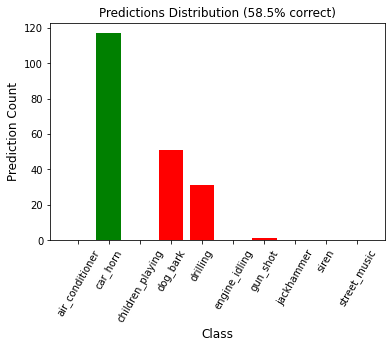

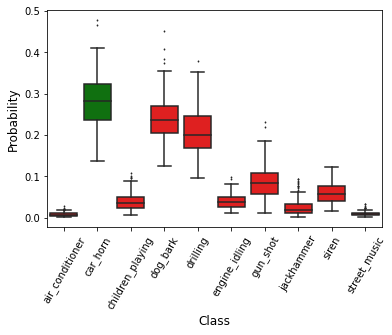

In [ ]:
analyse_model_predictions(1, mcSamples=20)

------------------------------
True category: 1

------------------------------
Model estimated probabilities:


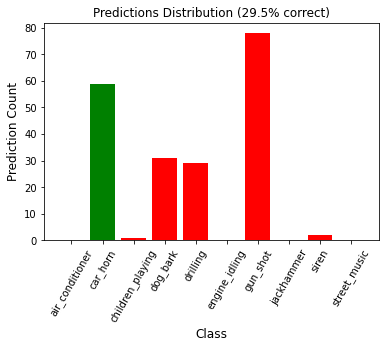

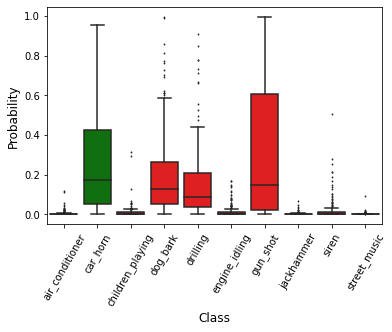

In [ ]:
analyse_model_predictions(2)

------------------------------
True category: 1

------------------------------
Model estimated probabilities:


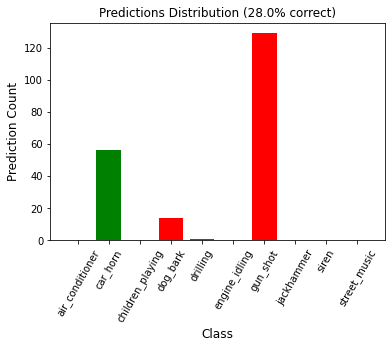

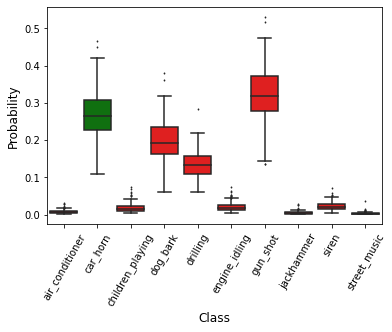

In [ ]:
analyse_model_predictions(2, mcSamples=20)

------------------------------
True category: 9

------------------------------
Model estimated probabilities:


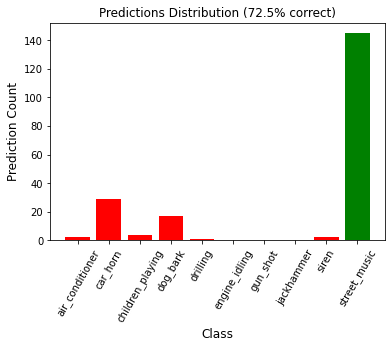

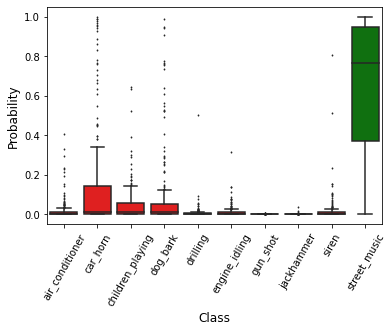

In [ ]:
analyse_model_predictions(543)

------------------------------
True category: 9

------------------------------
Model estimated probabilities:


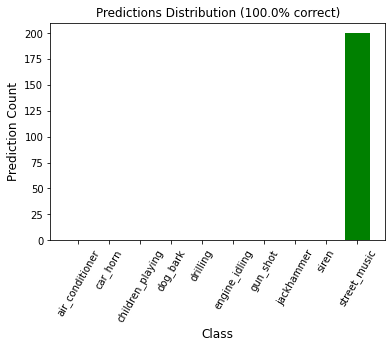

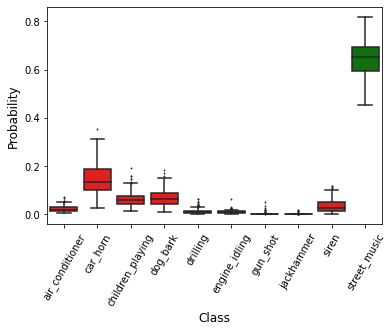

In [ ]:
analyse_model_predictions(543, mcSamples=20)

------------------------------
True category: 7

------------------------------
Model estimated probabilities:


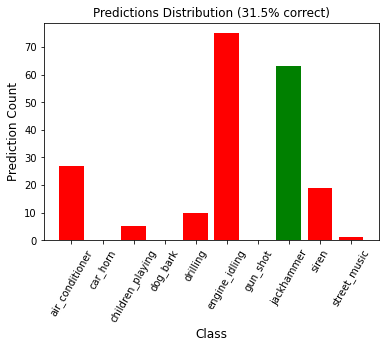

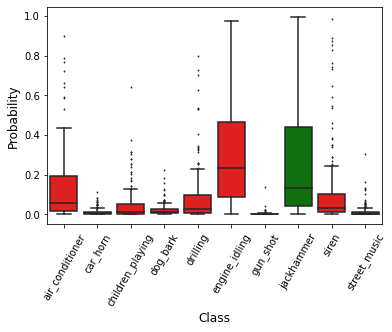

In [ ]:
analyse_model_predictions(379)

------------------------------
True category: 7

------------------------------
Model estimated probabilities:


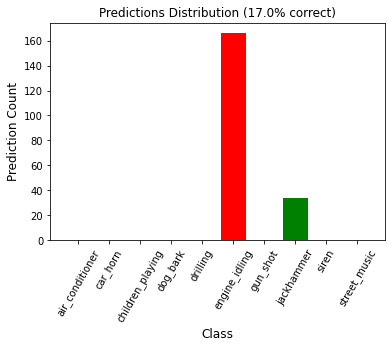

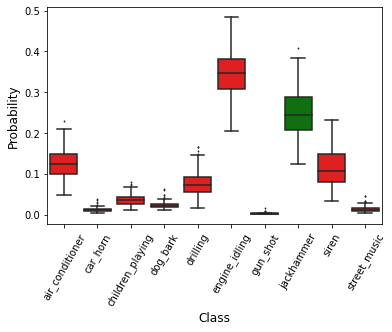

In [ ]:
analyse_model_predictions(379, mcSamples=20)

------------------------------
True category: 1

------------------------------
Model estimated probabilities:


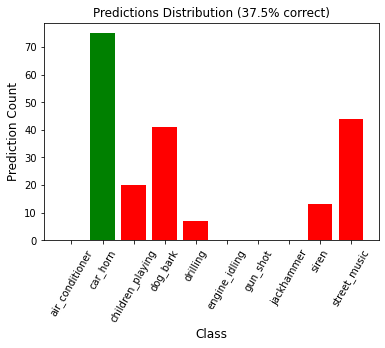

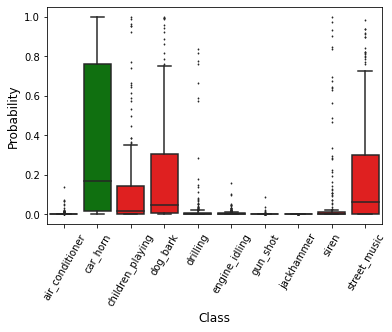

In [ ]:
analyse_model_predictions(600)

------------------------------
True category: 1

------------------------------
Model estimated probabilities:


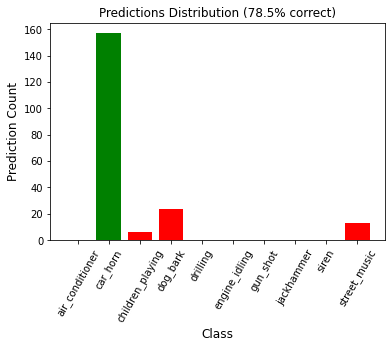

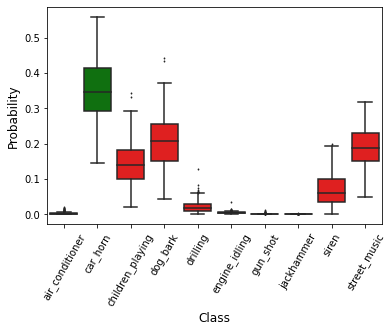

In [ ]:
analyse_model_predictions(600, mcSamples=20)

------------------------------
True category: 1

------------------------------
Model estimated probabilities:


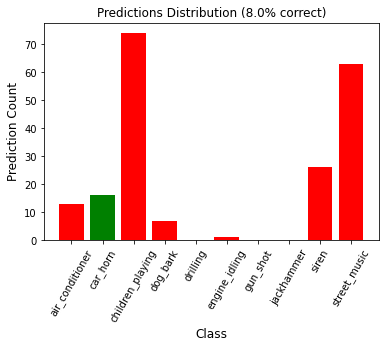

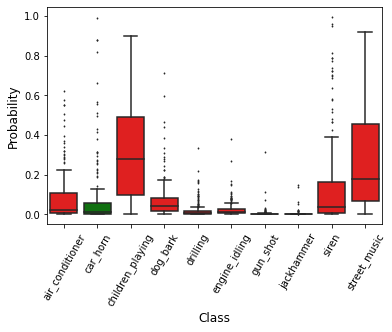

In [ ]:
analyse_model_predictions(601)

------------------------------
True category: 1

------------------------------
Model estimated probabilities:


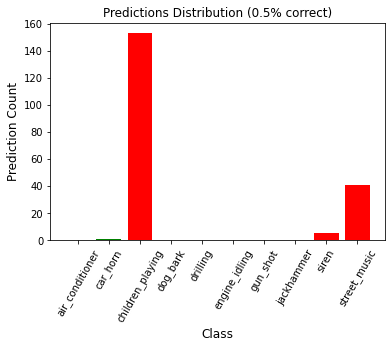

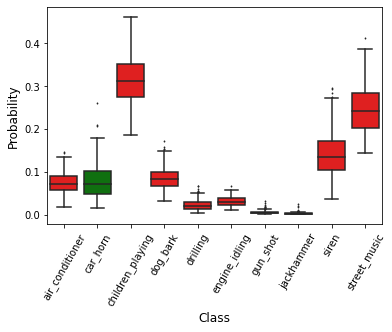

In [ ]:
analyse_model_predictions(601, mcSamples=20)

------------------------------
True category: 1

------------------------------
Model estimated probabilities:


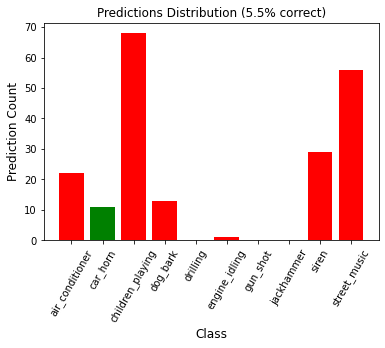

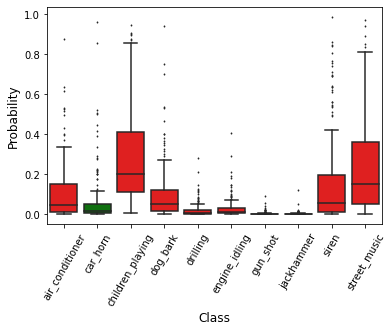

In [ ]:
analyse_model_predictions(602)

------------------------------
True category: 1

------------------------------
Model estimated probabilities:


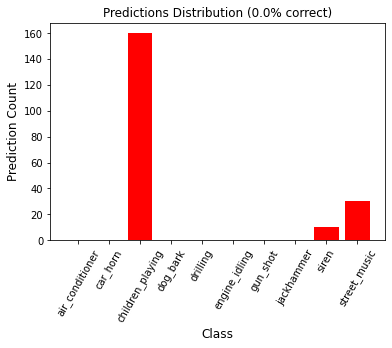

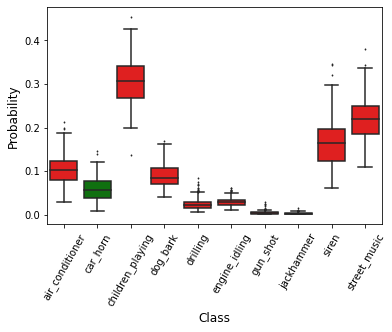

In [ ]:
analyse_model_predictions(602, mcSamples=20)

#### Uncertainty quantification using entropy

We can also make some analysis of the model's uncertainty across the full test set, instead of for individual values. One way to do this is to calculate the [entropy](https://en.wikipedia.org/wiki/Entropy_%28information_theory%29) of the distribution. The entropy is the expected information (or informally, the expected 'surprise') of a random variable, and is a measure of the uncertainty of the random variable. The entropy of the estimated probabilities for sample $i$ is defined as

$$
H_i = -\sum_{j=1}^{10} p_{ij} \text{log}_{2}(p_{ij})
$$

where $p_{ij}$ is the probability that the model assigns to sample $i$ corresponding to label $j$. The entropy as above is measured in _bits_. If the natural logarithm is used instead, the entropy is measured in _nats_.

The key point is that the higher the value, the more unsure the model is. Let's see the distribution of the entropy of the model's predictions across the MNIST and corrupted MNIST test sets. The plots will be split between predictions the model gets correct and incorrect.

In [ ]:
def plotEntropyDist(m, x_test, labels, mcSampleNo = 10):
    y_probs = np.mean(np.array([m(x_test).numpy() for i in range(mcSampleNo)]), axis=0)
    comp = np.argmax(y_probs, axis=1) == labels
    
    correct_inds = [i for i in range(x_test.shape[0]) if comp[i]]
    incorrect_inds = [i for i in range(x_test.shape[0]) if not comp[i]]

    entropy = -np.sum(y_probs * np.log2(y_probs), axis=1)

    n=-1
    for ent in (entropy[correct_inds], entropy[incorrect_inds]):
      n+=1
      meanEnt = np.mean(ent)
      p = sns.displot(data=ent, kind="hist")
      category = ("Correct", "Incorrect")[n]
      meanEnt = np.mean(ent)
      print("Mean entropy for " + category + "ly labelled data: " + str(meanEnt))
      numSamples = [len(correct_inds), len(incorrect_inds)][n]
      p.set(xlabel = "Entropy", ylabel = "Count", 
            title=category + 'ly labelled ({:.1f}% of total)'.format(numSamples / x_test.shape[0] * 100))
    
    return entropy

Mean entropy for Correctly labelled data: 1.9923214
Mean entropy for Incorrectly labelled data: 2.346724


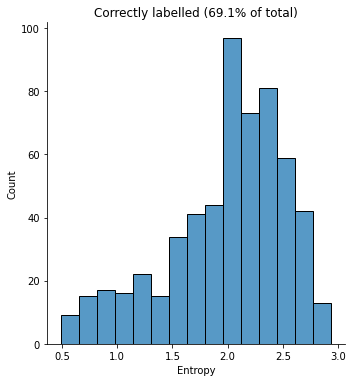

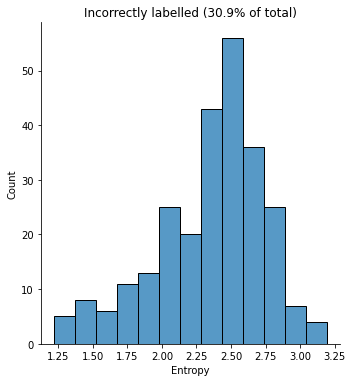

In [ ]:
ent, comp = plotEntropyDist(m, x_test, y_test, mcSampleNo=10)

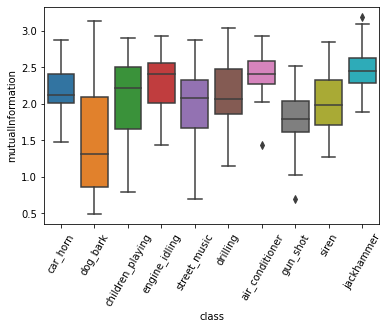

In [ ]:
sns.boxplot(data = pd.DataFrame({"class":[classList[i] for i in y_test], "mutualInformation": ent}), 
            x= "class", y = "mutualInformation");
plt.xticks(rotation=60);

We can also plot the distribution of the mutual information. Mutual information is an epistemic uncertainty measure.


In [ ]:
def plotMiDist(m, x_test, y_test, T = 10):
    y_probs_arr = np.array([m(x_test).numpy() for i in range(T)])
    y_probs = np.mean(y_probs_arr, axis=0)
    comp = np.argmax(y_probs, axis=1) == y_test

    ent = -np.sum(y_probs * np.log2(y_probs), axis=1) #Entropy of the average predicted probs
    avEnt = np.mean([-np.sum(y_ps * np.log2(y_ps), axis=1) for y_ps in y_probs_arr], axis = 0) #Mean of entropies calculated on different predicted probabilities

    comp = np.argmax(y_probs, axis=1) == y_test
    correct_inds = [i for i in range(x_test.shape[0]) if comp[i]]
    incorrect_inds = [i for i in range(x_test.shape[0]) if not comp[i]]

    mutualInformation = ent - avEnt
    
    n=-1
    for mi in (mutualInformation[correct_inds], mutualInformation[incorrect_inds]):
      n+=1
      plt.figure(n)

      meanMi = np.mean(mi)
      p = sns.displot(data=mi, kind="hist")
      category = ("Correct", "Incorrect")[n]
      meanMi = np.mean(mi)
      print("Mean mutual information for " + category + "ly labelled data: " + str(meanMi))
      numSamples = [len(correct_inds), len(incorrect_inds)][n]
      p.set(xlabel = "Mutual Information Score", ylabel = "Count", 
            title=category + 'ly labelled ({:.1f}% of total)'.format(numSamples / x_test.shape[0] * 100))

    return mutualInformation
    

Mean mutual information for Correctly labelled data: 0.68307966
Mean mutual information for Incorrectly labelled data: 0.79486334


<Figure size 432x288 with 0 Axes>

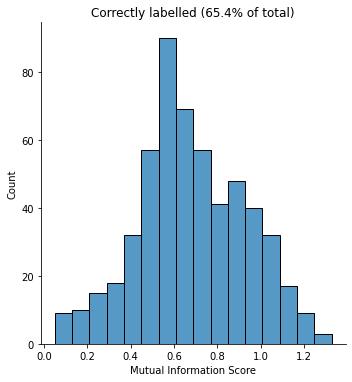

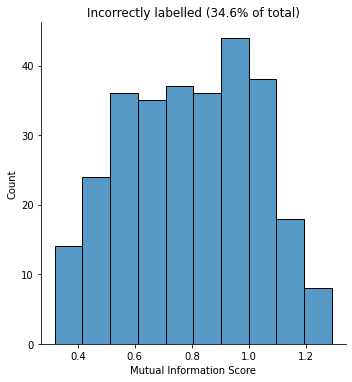

In [ ]:
mi = getMutualInformations(m, x_test, y_test, T=10)

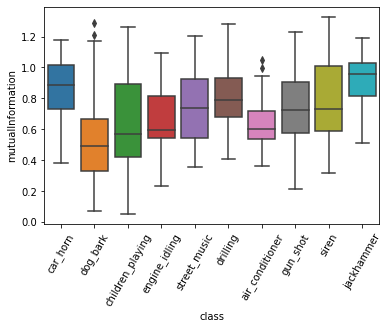

In [ ]:
sns.boxplot(data = pd.DataFrame({"class":[classList[i] for i in y_test], "mutualInformation": mi}), 
            x= "class", y = "mutualInformation");
plt.xticks(rotation=60);

We can also calcualte aleatoric uncertainty, using the average entropies. This is simpy the second term in the mutual information equation. It is the average entropy found over several predictions.


In [ ]:
def plotAleatoricEntropy(m, x_test, y_test, T = 10):
    y_probs_arr = np.array([m(x_test).numpy() for i in range(T)])
    y_probs = np.mean(y_probs_arr, axis=0)
    comp = np.argmax(y_probs, axis=1) == y_test

    ent = -np.sum(y_probs * np.log2(y_probs), axis=1) #Entropy of the average predicted probs
    avEnts = np.mean([-np.sum(y_ps * np.log2(y_ps), axis=1) for y_ps in y_probs_arr], axis = 0) #Mean of entropies calculated on different predicted probabilities

    comp = np.argmax(y_probs, axis=1) == y_test
    correct_inds = [i for i in range(x_test.shape[0]) if comp[i]]
    incorrect_inds = [i for i in range(x_test.shape[0]) if not comp[i]]

    mutualInformation = ent - avEnts

    n=-1
    for avEnt in (avEnts[correct_inds], avEnts[incorrect_inds]):
      n+=1
      meanAvEnt = np.mean(avEnt)
      p = sns.displot(data=avEnt, kind="hist")
      category = ("Correct", "Incorrect")[n]
      meanAvEnt = np.mean(avEnt)
      print("Mean aleatoric entropy for " + category + "ly labelled data: " + str(meanAvEnt))
      numSamples = [len(correct_inds), len(incorrect_inds)][n]
      p.set(xlabel = "Aleatoric Entropy Score", ylabel = "Count", 
            title=category + 'ly labelled ({:.1f}% of total)'.format(numSamples / x_test.shape[0] * 100))
      
    return mutualInformation, ent, avEnts
    

Mean mutual information for Correctly labelled data: 1.2964079
Mean mutual information for Incorrectly labelled data: 1.6644778


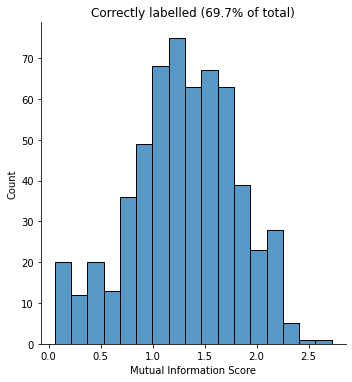

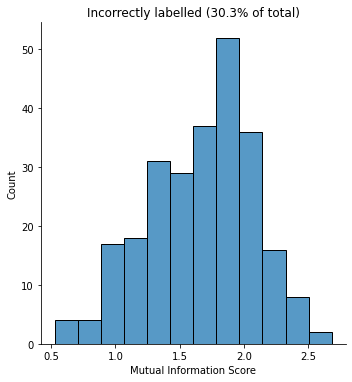

In [ ]:
mutualInformation, ent, avEnts = plotAleatoricEntropy(m, x_test, y_test, T=10)

We can also  plot these over the different classes to see on which there is the most uncertainty.

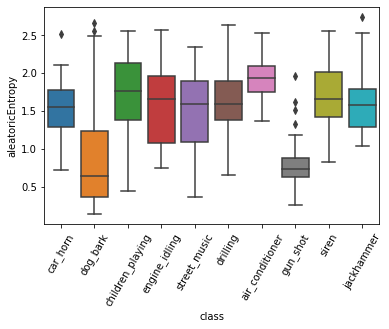

In [ ]:
sns.boxplot(data = pd.DataFrame({"class":[classList[i] for i in y_test], "aleatoricEntropy": avEnt}), 
            x= "class", y = "aleatoricEntropy");
plt.xticks(rotation=60);

Plot all at once. Here we plot the mutual information, aleatoric entropy, and predictive entropy in one function.

In [ ]:
#This is the only one needed to run for thesis codes
def uncertaintyEstimations(m, x_test, y_test, T = 10, plot=False):
    #y_probs_arr = np.array([np.mean([m(x_test).numpy() for j in range(25)], axis=0) for i in range(T)])
    y_probs_arr = np.array([m(x_test).numpy() for i in range(T)])
    print("Probs found")

    y_probs = np.mean(y_probs_arr, axis=0)
    comp = np.argmax(y_probs, axis=1) == y_test

    entropys = -np.sum(y_probs * np.log2(y_probs), axis=1) #Entropy of the average predicted probs
    maxEntropy = np.nanmax(entropys)
    
    avEnts = np.mean([-np.sum(y_ps * np.log2(y_ps), axis=1) for y_ps in y_probs_arr], axis = 0) #Mean of entropies calculated on different predicted probabilities
    maxAvEnt = np.nanmax(avEnts)

    comp = np.argmax(y_probs, axis=1) == y_test
    correct_inds = [i for i in range(x_test.shape[0]) if comp[i]]
    incorrect_inds = [i for i in range(x_test.shape[0]) if not comp[i]]

    mutualInformations = entropys - avEnts
    maxMutualInformations = np.nanmax(mutualInformations)

    xLimBuffer = 0.2

    if plot==True:    
      n=-1
      for avEnt in (avEnts[correct_inds], avEnts[incorrect_inds]):
        n+=1
        meanAvEnt = np.nanmean(avEnt)
        p = sns.displot(data=avEnt, kind="hist")
        category = ("Correct", "Incorrect")[n]
        print("Mean aleatoric entropy for " + category + "ly labelled data: " + str(meanAvEnt))
        numSamples = [len(correct_inds), len(incorrect_inds)][n]
        p.set(xlabel = "Aleatoric Entropy Score", ylabel = "Count", xlim = (0, maxAvEnt+xLimBuffer),
              title=category + 'ly labelled ({:.1f}% of total)'.format(numSamples / x_test.shape[0] * 100))
      
      n=-1
      for mi in (mutualInformations[correct_inds], mutualInformations[incorrect_inds]):
        n+=1
        plt.figure(n)

        meanMi = np.nanmean(mi)
        p = sns.displot(data=mi, kind="hist") #Could w change count to proportion???
        category = ("Correct", "Incorrect")[n]
        print("Mean mutual information for " + category + "ly labelled data: " + str(meanMi))
        numSamples = [len(correct_inds), len(incorrect_inds)][n]
        p.set(xlabel = "Mutual Information Score", ylabel = "Count", xlim = (0, maxMutualInformations+xLimBuffer),
              title=category + 'ly labelled ({:.1f}% of total)'.format(numSamples / x_test.shape[0] * 100))

      n=-1
      for ent in (entropys[correct_inds], entropys[incorrect_inds]):
        n+=1
        meanEnt = np.nanmean(ent)
        p = sns.displot(data=ent, kind="hist")
        category = ("Correct", "Incorrect")[n]
        print("Mean predictive entropy for " + category + "ly labelled data: " + str(meanEnt))
        numSamples = [len(correct_inds), len(incorrect_inds)][n]
        p.set(xlabel = "Predictive Entropy", ylabel = "Count", xlim = (0, maxEntropy+xLimBuffer),
              title=category + 'ly labelled ({:.1f}% of total)'.format(numSamples / x_test.shape[0] * 100))
      
    return mutualInformations, entropys, avEnts
    

Probs found


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log2
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


Mean aleatoric entropy for Correctly labelled data: 1.3002646
Mean aleatoric entropy for Incorrectly labelled data: 1.5887674
Mean mutual information for Correctly labelled data: 0.8312479
Mean mutual information for Incorrectly labelled data: 0.92655903
Mean predictive entropy for Correctly labelled data: 2.1289327
Mean predictive entropy for Incorrectly labelled data: 2.5153263


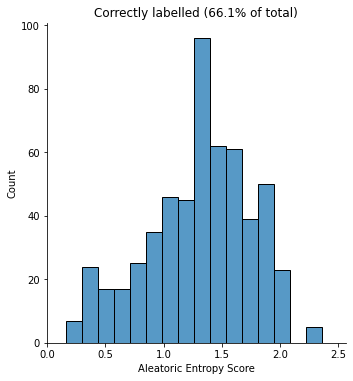

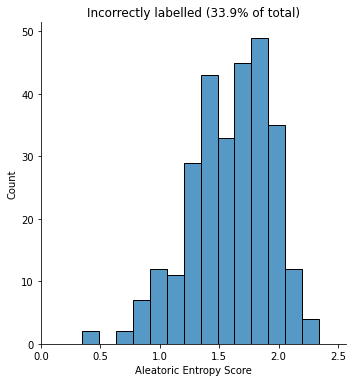

<Figure size 432x288 with 0 Axes>

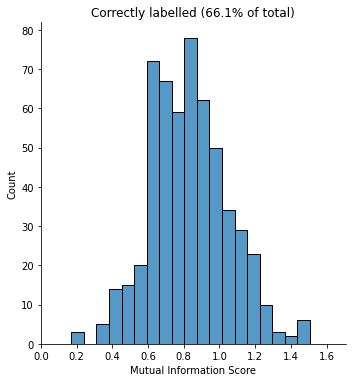

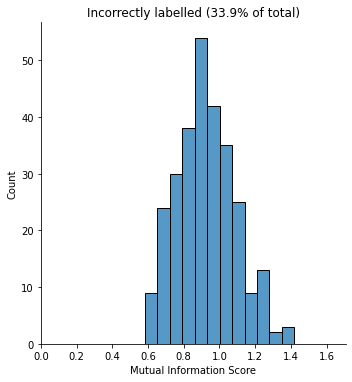

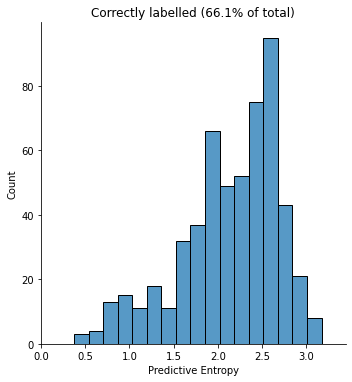

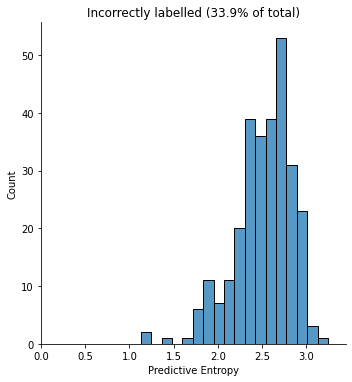

In [ ]:
#var = uncertaintyEstimations(m, x_test, y_test, T=100, plot = True)
mutualInformations, ents, avEnts = uncertaintyEstimations(m, x_test, y_test, T=50, plot = True)


aleatoric: aleatoric entropy

In [ ]:
df=pd.DataFrame({"class":[classList[i] for i in y_test], "aleatoricEntropy": avEnts})

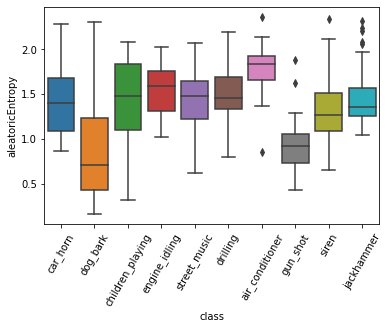

In [ ]:
sns.boxplot(data = df, 
            x= "class", y = "aleatoricEntropy");

plt.xticks(rotation=60);


Epistemic and aleatoric: predictive entropy

In [ ]:
df = pd.DataFrame({"class":[classList[i] for i in y_test], "predictiveEntropy": ents})
dfSums = df.groupby(["class"]).sum()

dfSums

,predictiveEntropy
class,
air_conditioner,261.048218
car_horn,78.262543
children_playing,230.312073
dog_bark,154.083267
drilling,233.556137
engine_idling,219.109192
gun_shot,57.298866
jackhammer,244.667892
siren,183.868179


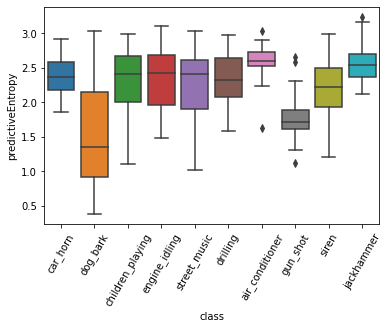

In [ ]:
sns.boxplot(data = df, 
            x= "class", y = "predictiveEntropy");
plt.xticks(rotation=60);

epistemic: MI

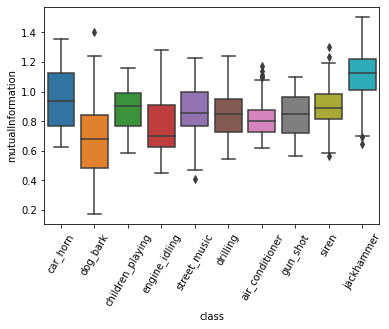

In [ ]:
df = pd.DataFrame({"class":[classList[i] for i in y_test], "mutualInformation": mutualInformations})
sns.boxplot(data = df, 
            x= "class", y = "mutualInformation");
plt.xticks(rotation=60);

Next we can permute some the data to show how this affects the uncertainty. 

